# Boosting & Stacking

Boostring(부스팅)은 약한 learner(학습기)를 여러 개 연결하여 강한 학습기를 만드는 ensemble 기법이다. Boosting의 main idea는 **앞의 모델을 보완**해나가면서 일련의 learn(학습기)를 학습시키는 것이다. 어떤 방법으로 보완을 할까? 앞으로 살펴보도록 하자.

Boostring의 종류
* AdaBoost(아다부스트, Adaptive Boostring)
* Gradient Boostring(그레디언트 부스팅)
* XGBoost
* CatBoost

In [1]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np

# Classifer를 입력으로 받고, 결정경계를 그려주는 Help 함수 입니다.
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

## 1 AdaBoost
* 이전 learner(학습기)를 보완하는 새로운 학습기를 만드는 방법은 이전 모델이 과소적합했던 훈련 샘플의 가중치를 더 높이는 것이다. 이렇게 하면 새로운 학습기는 학습하기 어려운 샘플에 점점 더 맞춰지게 된다.
    * 아다부스트 분류기를 만들려면 기반이 되는 첫 번째 분류기(예를 들어 결정 트리)를 훈련 세트에서 훈련시키고 예측을 만든다.
    * 잘못 분류된 훈련 샘플의 가중치를 상대적으로 높인다.
    * 두 번째 분류기는 업데이트된 가중치를 사용해 훈련 세트에서 훈련하고 다시 예측을 만든다.

그림 추가

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [3]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

/Users/kakao/.pyenv/versions/3.6.3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.5, n_estimators=200, random_state=42)

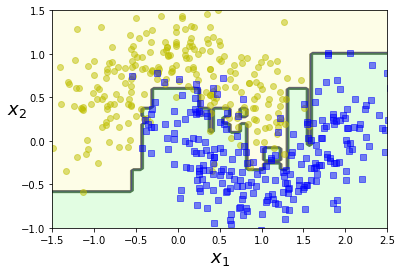

In [4]:
plot_decision_boundary(ada_clf, X, y)

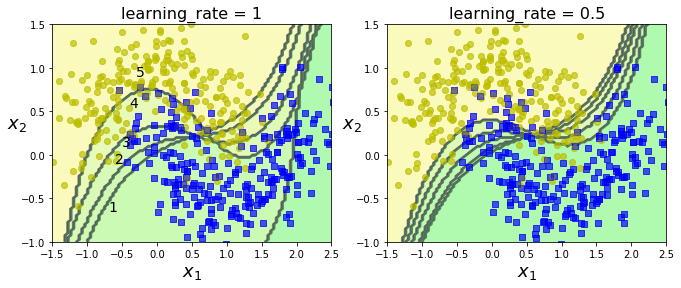

In [5]:
# 5개의 SVM을 학습하고 5개의 연속된 예측기의 결정경계를 살펴봄(Adaboost 처럼 다음 예측기는 그 이전의 예측기가 보완되는 것을 시뮬레이션)
# SVM은 속도가 많이 느리기 때문에 Adaboost의 base learner로는 사용 부적합

from sklearn.svm import SVC

m = len(X_train)

plt.figure(figsize=(11, 4))
for subplot, learning_rate in ((121, 1), (122, 0.5)):
    sample_weights = np.ones(m)
    plt.subplot(subplot)
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.05, gamma="auto", random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights)
        y_pred = svm_clf.predict(X_train)
        sample_weights[y_pred != y_train] *= (1 + learning_rate)
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 121:
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5,  0.10, "3", fontsize=14)
        plt.text(-0.4,  0.55, "4", fontsize=14)
        plt.text(-0.3,  0.90, "5", fontsize=14)

plt.show()

Moons 데이터셋에 훈련시킨 다섯 개의 연속된 예측기의 결정 경계이다. (이 모델은 규제를 강하게 한 RBF 커널 SVM 분류기이다.) 첫 번째 분류기가 많은 샘플을 잘못 분류해서 이 샘플들의 가중치가 높아졌다. 따라서 두 번째 분류기는 이 샘플들을 더 정확히 예측하게 된다.

오른쪽 그래프는 학습률을 반으로 낮춘 것만 빼고 똑같은 일련의 예측기를 나타낸 것이다. (즉, 잘못 분류된 샘플의 가중치는 반복마다 절반 정도만 높아진다.)

이런 연속된 학습 기법은 경사 하갑법과 비슷한 면이 존재한다. 경사 하강법은 비용 함수를 최소화하기 위해 한 예측기의 모델 파라미터를 조정해가는 반면 아다부스트는 점차 더 좋아지록 앙상블에 예측기를 추가한다.

모든 예측기가 훈련을 마치면 이 앙상블은 bagging이나 pasting과 비슷한 방식으로 예측을 생성. 하지만 가중치가 적용된 훈련 세트의 전반적인 정확도에 따라 예측기마다 다른 가중치가 적용됨

### Adaboost  algorithm

1. 각 샘플 가중치 $w^{(i)}$는 초기에 $\frac{1}{m}$로 초기화
2. 가중치가 적용된 에러율 $r_1$이 훈련 세트에 대해 계산됨. 
$$r_{j} = \frac{\hat{y}_{j}^{(i)}\neq y^{(i)}}{\sum_{i=1}^{m}w^{i}} \text{ where } \hat{y}_{j}^{(i)} \text{ is a prediction of i-th sample from j-th base learner}$$
3. 에러율을 기반으로 예측기의 가중치 $\alpha_1$이 계산됨.
$$\alpha_j=\eta \log{\frac{1-r_j}{r_j}}$$
4. 예측기의 가중치를 기반으로 샘플의 가중치를 업데이트. 즉, 잘못 분류된 샘플의 가중치가 증가
$$w^{(i)} = w^{(i)} \text{ where } \hat{y}_j^{(i)}=y^{(i)}$$
$$w^{(i)} = w^{(i)} \exp{\alpha_j} \text{ where } \hat{y}_j^{(i)} \neq y^{(i)}$$
5. 모든 샘플의 가중치를 정규화 ($\sum_{i=1}^{m}w^{(i)}$로 나누어줌)
6. 새 예측기가 업데이트된 가중치를 사용해 훈련되고, 1~5의 과정이 다시 반복

### Prediction using Adaboost algorithm ?? 식이 이상
$$\hat{y}(x)=\arg \max_k \sum_{i=1}^{N}\alpha_j$$

### SKlearn에서 사용하는 Adaboost algorithm : SAMME

* Sklearn에서는 SAMME라는 아다부스트의 다중 클래스 버전을 사용. $K$는 클래스의 수이며 예측기의 가중치를 구하는 식은 아래와 같음
$$\alpha_j=\eta (\log{\frac{1-r_j}{r_j}}+\log(K-1)$$
* 예측기가 클래스의 확률을 추정하는 경우는 SAMME.R를 사용
$$\alpha_j=\eta{\frac{K-1}{K}}y\log{\hat{y}_j}$$ 여기에서 $y$는 정답클래스일때는 1 아닐때는 $-\frac{1}{1-K}$이고, $\hat{y}_j$는 j번째 예측기가 만든 클래스 확률. 예측기별 클래스 확률을 계산해서 합한 후 확률이 가장 높은 클래스를 선택하며 관련 공식은 다음과 같음 $$\hat{y}(x)=\arg \max_k \sum_{j=1}^{N}(K-1)(\log{\hat{y}_j-\frac{1}{K}\sum_{k=0}^{K}\hat{y}_j})$$


In [6]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.5, n_estimators=200, random_state=42)

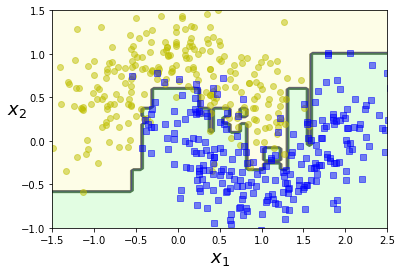

In [7]:
plot_decision_boundary(ada_clf, X, y)

# 2 Gradient boosting
Gradient boosting은 Adaboost와 동일하게 앙상블 기법과, 이전까지의 오차를 보정하도록 예측기를 순차적으로 추가하는 기법을 사용한다. 하지만 Adaboost와는 달리 반복마다 샘플의 가중치를 수정하는 대신, 이전 예측기가 만든 잔여 오차(residual error)에 새로운 예측기를 학습

In [8]:
# Noise가 섞인 임의의 데이터 셋을 생성하여 테스트
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

### Gradient Boosted Regression Tree (GBRT)

> Example 1 : Decision tree 3개를 이용하여, GBRT를 직접 구현

In [9]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [10]:
# 이전 예측기가 만든 잔여오차가 y2
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)  # 잔여오차 y2에 학습

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [11]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [13]:
# 테스트를 위해 값을 생성
X_new = np.array([[0.8]])

In [14]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [15]:
y_pred

array([0.75026781])

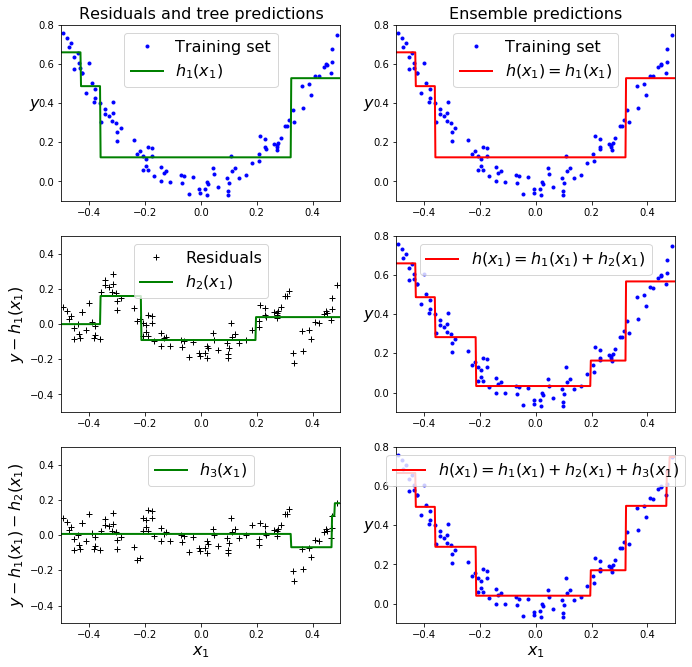

In [16]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.show()

> Sklearn의 GradientBoostingRegression을 직접사용
 - 첫 번째 GBRT는 base learner가 3개, learning rate가 1.0 입니다.
 - 두 번째 GBRT는 base learner가 200개, learning rate가 0.1 입니다.

In [17]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=1.0, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=3, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)

In [18]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=200, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)

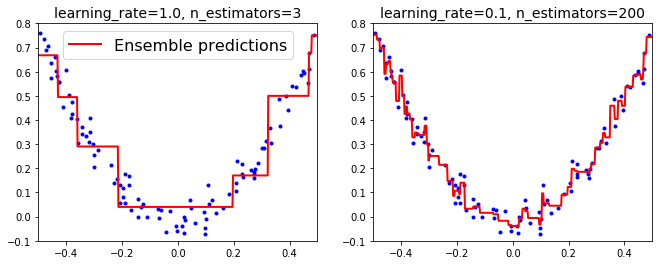

In [19]:
plt.figure(figsize=(11,4))

plt.subplot(121)
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)

plt.show()

왼쪽 그림의 경우, 훈련 세트를 학습하기에는 트리가 충분하지 않아서 underfitting이 발생한 반면 오른쪽 그림의 경우, 트리가 너무 많아서 overfitting이 발생했다.

그러면 최적의 트리 수를 찾기 위한 방법은?
 - 조기 종료 기법 1 (`staged_predict()`): 훈련의 각 단계에서 앙상블에 의해 만들어진 예측기를 순회하는 반복자를 반환. 즉 모든 base learner 및 그의 앙상블을 훈련시킨후, 그 앙상블을 순회하면서 검증값을 구함

In [20]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors)

gbrt_best = GradientBoostingRegressor(max_depth=2,n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=55, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)

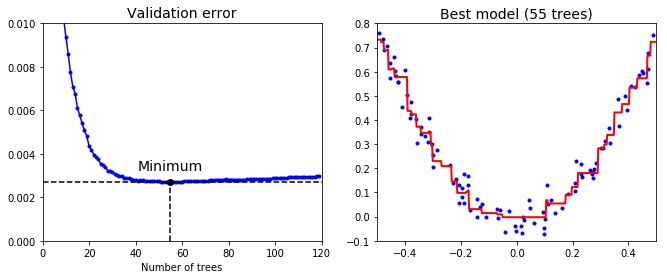

In [22]:
min_error = np.min(errors)

plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)

plt.show()

 - 조기 종료 기법 2 : 검증 오차가 더 이상 향상되지 않으면 훈련을 멈춤

In [23]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

In [24]:
print(gbrt.n_estimators)

61


In [25]:
print("Minimum validation MSE:", min_val_error)

Minimum validation MSE: 0.002712853325235463


Sklearn에서 제공하는 `GradientBoostringRegressor`는 각 트리가 훈련할 때 사용할 훈련 샘플의 비율을 지정할 수 있다. 이 경우, 각 base learner는 random하게 선택된 훈련 샘플로 학습된다. 편향이 높아지는 대신, 분산이 낮아지게 된다.

## 3. XgBoost

In [26]:
try:
    import xgboost
except ImportError as ex:
    print("Error: the xgboost library is not installed.")
    xgboost = None

In [29]:
if xgboost is not None:
    xgb_reg = xgboost.XGBRegressor(random_state=42)
    xgb_reg.fit(X_train, y_train)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    print("Validation MSE:", val_error)

Validation MSE: 0.0028512559726563943


In [30]:
if xgboost is not None:
    xgb_reg.fit(X_train, y_train,
                eval_set=[(X_val, y_val)], early_stopping_rounds=2)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    print("Validation MSE:", val_error)

[0]	validation_0-rmse:0.286719
Will train until validation_0-rmse hasn't improved in 2 rounds.
[1]	validation_0-rmse:0.258221
[2]	validation_0-rmse:0.232634
[3]	validation_0-rmse:0.210526
[4]	validation_0-rmse:0.190232
[5]	validation_0-rmse:0.172196
[6]	validation_0-rmse:0.156394
[7]	validation_0-rmse:0.142241
[8]	validation_0-rmse:0.129789
[9]	validation_0-rmse:0.118752
[10]	validation_0-rmse:0.108388
[11]	validation_0-rmse:0.100155
[12]	validation_0-rmse:0.09208
[13]	validation_0-rmse:0.084791
[14]	validation_0-rmse:0.078699
[15]	validation_0-rmse:0.073248
[16]	validation_0-rmse:0.069391
[17]	validation_0-rmse:0.066277
[18]	validation_0-rmse:0.063458
[19]	validation_0-rmse:0.060326
[20]	validation_0-rmse:0.0578
[21]	validation_0-rmse:0.055643
[22]	validation_0-rmse:0.053943
[23]	validation_0-rmse:0.053138
[24]	validation_0-rmse:0.052415
[25]	validation_0-rmse:0.051821
[26]	validation_0-rmse:0.051226
[27]	validation_0-rmse:0.051135
[28]	validation_0-rmse:0.05091
[29]	validation_0-rmse

In [31]:
%timeit xgboost.XGBRegressor().fit(X_train, y_train) if xgboost is not None else None

4.76 ms ± 261 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [32]:
%timeit GradientBoostingRegressor().fit(X_train, y_train)

12 ms ± 550 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## 4. Stacking

Stacked generalization(Stacking) : Ensemble에 속한 모든 예측기의 예측을 취합하는 간단한 함수(예를 들어, 투표 or 평균)를 사용하는 대신, 예측기의 모든 결과를 취합하는 새로운 학습 모델을 추가적으로 만드는 것이다. 각각의 예측기의 결과를 마지막 blender(또는 meta learner)가 입력으로 받아 최종 예측을 출력한다.

Blender를 학습시키는 일반적인 방법은 hold out 세트를 이용하는 것이다.
 - 먼저 훈련 세트를 두 개의 subset으로 나눈다.
 - 첫 번째 subset은 첫 번째 layer의 예측을 훈련시키기 위해 사용
 - 첫 번째 layer의 예측기를 사용해 두 번째 subset에 대한 예측을 생성
 - Hold out set와 입력 특성으로 사용하는 새로운 훈련 세트를 생성
 - Target 값은 그대로 쓰고 앞에서 예측한 값을 입력 특성으로 사용하는 새로운 훈련 세트를 생성 (3차원)
  - Blender가 새 훈련 세트로 훈련 (첫 번째 layer의 예측을 가지고 target value를 예측하도록 학습)

사실 이런 방식의 블렌더를 여러 개 훈련시키는 것도 가능합니다. (예를 들어 하나는 선형 회귀로, 다른 하나는 랜덤 포레스트 회귀로). 그러면 블렌더만의 레이어가 생성됩니다. 이렇게 하려면 훈련 세트를 세 개의 서브셋으로 나눕니다. 첫 번째 세트는 첫 번째 레이어를 훈련시키는 데 사용되고 두 번째 세트는(첫 번째 레이어의 예측기로) 두 번째 레이어를 훈련시키기 위한 훈련 세트를 만드는 데 사용됩니다. 그리고 세 번째 세트는(두 번째 레이어의 예측기로) 세 번째 레이어를 훈련시키기 위한 훈련 세트를 만드는 데 사용됩니다. 작업이 끝나면 각 레이어를 차례대로 실행해서 새로운 샘플에 대한 예측을 만들 수 있습니다.